In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


# Notebook question: How well do the Generated Events Match Up with Real Events?

## Import Statements

In [2]:
from datetime import datetime
import pytz
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sustaingym.envs.evcharging import GMMsTraceGenerator, RealTraceGenerator
from sustaingym.envs.evcharging import utils
from sustaingym.envs.evcharging.train_gmm_model import preprocess

## Create Generators

In [3]:
ag = GMMsTraceGenerator('caltech', 'Summer 2019')
rg = RealTraceGenerator('caltech', 'Summer 2019', sequential=True)
rg = RealTraceGenerator('caltech', 'Summer 2019', sequential=False)

## Real Events

In [4]:
def plot_gmm_fit(site):
    la_tz = pytz.timezone('America/Los_Angeles')
    dtf = '%Y-%m-%d'
    PATH = 'gmms_ev_charging/{site}/{date_range} 30/'
    PATH = 'sustaingym/envs/evcharging/gmms_ev_charging/{site}/{date_range} 30/'

    seasons = ['Summer 2019', 'Fall 2019', 'Spring 2020', 'Summer 2021']
    periods = []
    dfs = []
    gmms = []

    pdfs = []

    for season in seasons:
        period = \
            (datetime.strptime(utils.DEFAULT_PERIOD_TO_RANGE[season][0], dtf).replace(tzinfo=la_tz),
            datetime.strptime(utils.DEFAULT_PERIOD_TO_RANGE[season][1], dtf).replace(tzinfo=la_tz))
        periods.append(period)

        df = preprocess(utils.get_real_events(period[0], period[1], site), filter=False)
        dfs.append(df)

        path = PATH.format(site=site,
                        date_range=period[0].strftime(dtf) + " " +  period[1].strftime(dtf))
        
        gmm = utils.load_gmm_model(site, period[0], period[1], 30)['gmm']

        gmms.append(gmm)

        # display predicted scores by the model as a contour plot
        arr = np.linspace(0.0, 1.0)
        dep = np.linspace(0.0, 1.0)

        # Fit gmm on mesh to generate contour lines
        X, Y = np.meshgrid(arr, dep)
        Xr, Yr = X.ravel(), Y.ravel()

        # Calculate conditional mean for estimated departure, requested energy
        weights = np.expand_dims(gmm.weights_, (1, 2))
        n_components = len(gmm.weights_)
        N = len(Xr)
        x_b = np.vstack((Xr, Yr))  # shape (2, N)

        conditional_means = []
        for i in range(n_components):
            mu_a = np.expand_dims(gmm.means_[i, 2:], 1)
            mu_b = np.expand_dims(gmm.means_[i, :2], 1)
            mu_aa_precision = gmm.precisions_[i, 2:, 2:]
            mu_ab_precision = gmm.precisions_[i, 2:, :2]
            cond_a_b = mu_a - np.linalg.inv(mu_aa_precision) @ mu_ab_precision @ (x_b - mu_b)
            conditional_means.append(cond_a_b)
        conditional_means = np.array(conditional_means)
        conditional_mean = np.sum(weights * conditional_means, axis=0).T  # N, 2

        gmm_input = pd.DataFrame({
            'arrival_time': Xr,
            'departure_time': Yr,
            'estimated_departure_time': conditional_mean[:, 0],
            'requested_energy (kWh)': conditional_mean[:, 1]
        })
        Z = gmm.score_samples(gmm_input)
        Z = Z.reshape(X.shape)

        pdfs.append((X, Y, Z))

    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
    for row in range(2):
        for col in range(2):
            i = row * 2 + col
            X, Y, Z = pdfs[i]
            x = X * 288 # rescale to 5-min periods
            y = Y * 288
            # same with arrivals and departures
            arr_time = dfs[i].arrival_time * 288
            dep_time = dfs[i].departure_time * 288

            cp = ax[row][col].contourf(x, y, Z, cmap='Blues', alpha=0.5)
            ax[row][col].scatter(arr_time, dep_time, marker='+', alpha=0.1, color='red')
            ax[row][col].set_title(f'{seasons[i]}', fontsize=14)

    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('arrival time (5-min periods)', fontsize=14)
    plt.ylabel('departure time (5-min periods)', fontsize=14)
    fig.subplots_adjust(right=0.8)
    if site == 'caltech':
        fig.suptitle(f'GMM Fit for the Caltech site', fontsize=16)
    else:
        fig.suptitle(f'GMM Fit for the JPL site', fontsize=16)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cp, cax=cbar_ax)
    plt.savefig(f'gmms_fit_{site}.png', dpi=300)

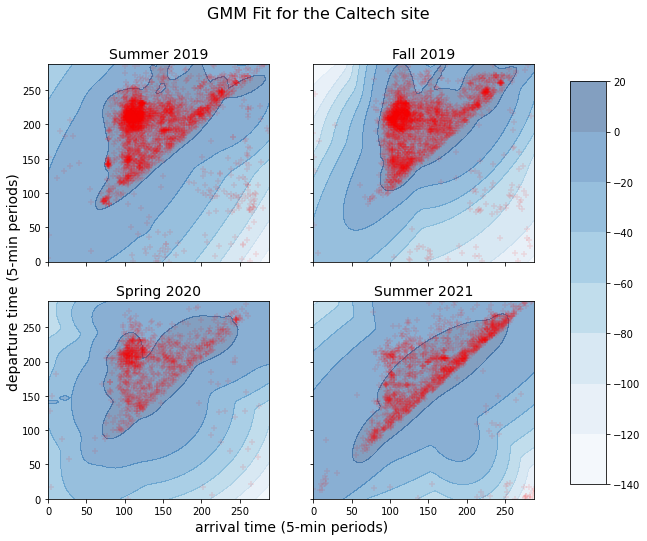

In [5]:
plot_gmm_fit('caltech')

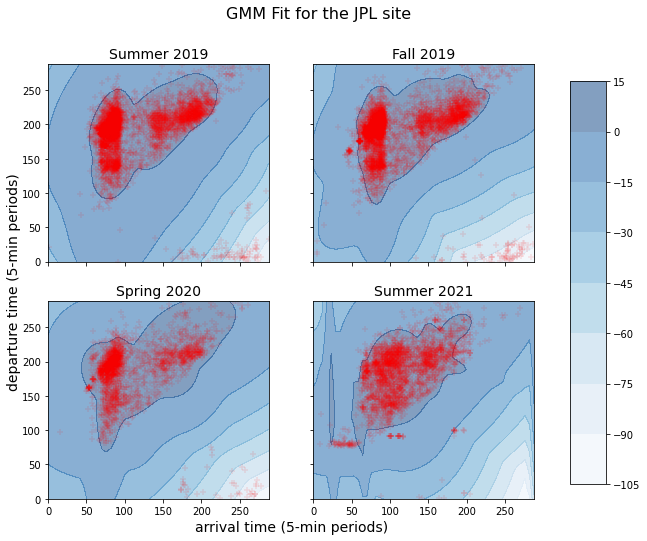

In [6]:
plot_gmm_fit('jpl')